In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

tire_scaling = 0.55

lat_coeffs = [0.349, -0.00115, 8.760, 730.300, 1745.322, 0.0139, -0.000277, 1.02025435, 0, 0, 0, 0, 0, 0, 0, 0.00362, -0.0143, -0.0116]

long_coeffs = [0.46024966176377113, 4000.509873697152, 1097.1712081460967, 202.18848632159495, 100.8812198037175, -0.2557010431649166, 0.3066955241461764, 0.011822770671297778, -1.9521015799737094, 0, 0, 0, 0, 0]


In [2]:
def _com_long(SA: float, SR: float, FX: float, FY: float, Ca: float):
    FY = abs(FY)
    try:
        if (SR**2 * FY**2 + FX**2 * (np.tan(SA))**2 == 0 or Ca == 0):
            SA += 1e-64
            SR += 1e-64
            FX += 1e-64
            FY += 1e-64
            Ca += 1e-64
    except:
        pass

    adjusted_FX = ((FX * FY) / np.sqrt(SR**2 * FY**2 + FX**2 * (np.tan(SA))**2)) * \
            (np.sqrt(SR**2 * Ca**2 + (1 - SR)**2 * (np.cos(SA))**2 * FX**2) / Ca)
    
    return adjusted_FX

In [3]:
def _com_lat(SA: float, SR: float, FX: float, FY: float, Cs: float):
    FX = abs(FX)
    try:
        if (SR**2 * FY**2 + FX**2 * (np.tan(SA))**2 == 0 or Cs == 0):
            SA += 1e-64
            SR += 1e-64
            FX += 1e-64
            FY += 1e-64
            Cs += 1e-64
    except:
        pass

    adjusted_FY = ((FX * FY) / np.sqrt(SR**2 * FY**2 + FX**2 * (np.tan(SA))**2)) * \
        (np.sqrt((1 - SR)**2 * (np.cos(SA))**2 * FY**2 + (np.sin(SA))**2 * Cs**2) / (Cs * np.cos(SA)))
        
    return adjusted_FY

In [4]:
def _long_pacejka(data: list[float]):
    FZ = data[0] / 1000
    SR = data[1] * 100
    [b0, b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13] = long_coeffs

    if FZ <= 0:
        return 0
    else:
        C = b0
        D = FZ * (b1 * FZ + b2)
        
        BCD = (b3 * FZ**2 + b4 * FZ) * np.exp(-1 * b5 * FZ)
        B = BCD / (C * D)
        H = b9 * FZ + b10

        E = (b6 * FZ**2 + b7 * FZ + b8) * (1 - b13 * np.sign(SR + H))

        V = b11 * FZ + b12
        Bx1 = B * (SR + H)

        return tire_scaling * (D * np.sin(C * np.arctan(Bx1 - E * (Bx1 - np.arctan(Bx1)))) + V)

In [5]:
def _lat_pacejka(data: list[float]):
    FZ = data[0]
    SA = data[1] * 180 / np.pi
    IA = data[2] * 180 / np.pi
    [a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, a16, a17] = lat_coeffs

    if FZ <= 0:
        return 0
    else:
        C = a0
        D = FZ * (a1 * FZ + a2) * (1 - a15 * IA**2)
        
        BCD = a3 * np.sin(np.arctan(FZ / a4) * 2) * (1 - a5 * abs(IA))
        B = BCD / (C * D)
        H = a8 * FZ + a9 + a10 * IA

        E = (a6 * FZ + a7) * (1 - (a16 * IA + a17) * np.sign(SA + H))

        V = a11 * FZ + a12 + (a13 * FZ + a14) * IA * FZ
        Bx1 = B * (SA + H)

        return tire_scaling * (D * np.sin(C * np.arctan(Bx1 - E * (Bx1 - np.arctan(Bx1)))) + V)

In [6]:
def _zero_protection(SA: float, SR: float):
    if type(SA) == float or type(SA) == int:
        if SA == 0:
            SA += 1e-64
    else:
        if SA.any() == 0:
            SA += 1e-64
        
    if type(SR) == float or type(SR) == int:
        if SR == 0:
            SR += 1e-64
    else:
        if SR.any() == 0:
            SR += 1e-64

    return [SA, SR]

In [7]:
def _get_comstock_forces(SA: float, SR: float, FZ: float, IA: float):
    SA, SR = _zero_protection(SA, SR)

    FX = _long_pacejka([FZ, SR])
    FY = _lat_pacejka([FZ, SA, IA])

    Ca = (_long_pacejka([FZ, 1 / 100]) - _long_pacejka([FZ, 0])) * (180 / np.pi) # slip stiffness
    Cs = (_lat_pacejka([FZ, 1 * np.pi / 180, IA]) - _lat_pacejka([FZ, 0, IA])) * 100 # cornering stiffness

    adj_FX = _com_long(SA, SR, FX, FY, Ca)
    adj_FY = _com_lat(SA, SR, FX, FY, Cs)

    return [adj_FX, adj_FY, FZ]

Text(0.5, 1.0, 'Longitudinal Force vs Slip Ratio')

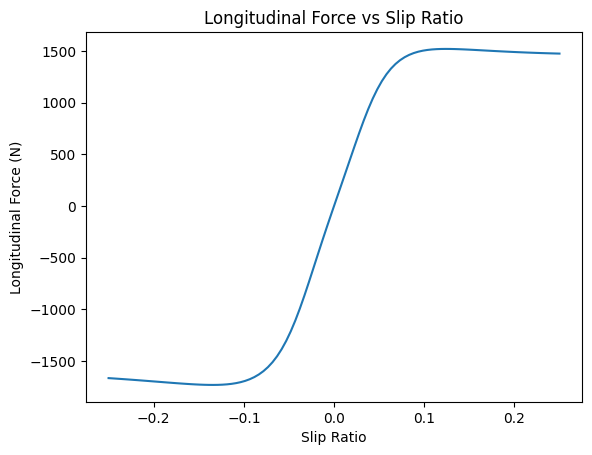

In [8]:
# SA_sweep = np.linspace(-25 * np.pi / 180, 25 * np.pi / 180, 100)
SR_sweep = np.linspace(-0.25, 0.25, 100)
normal_force = 890

lat_forces = []
long_forces = []
# for slip_angle in SA_sweep:
for slip_ratio in SR_sweep:
    # lat_force = _get_comstock_forces(slip_angle, 0, normal_force, 0)[1]
    # lat_forces.append(lat_force)
    long_force = _get_comstock_forces(0, slip_ratio, normal_force, 0)[0]
    long_forces.append(long_force)

# plt.plot(SA_sweep * 180 / np.pi, lat_forces)
plt.plot(SR_sweep, long_forces)
plt.xlabel("Slip Ratio")
plt.ylabel("Longitudinal Force (N)")
plt.title("Longitudinal Force vs Slip Ratio")

In [9]:
# Setup

FZ = 1000

model_SA_data = np.linspace(0, np.pi / 2, 1000)
model_SR_data = np.linspace(0, 1, 1000)

SA, SR = np.meshgrid(model_SA_data, model_SR_data)

FX = _get_comstock_forces(SA, SR, FZ, 0)[0]
FY = _get_comstock_forces(SA, SR, FZ, 0)[1]

# FX2 = tire_model._get_comstock_forces(SA, SR, 500, 0 * np.pi / 180)[0]
# FY2 = tire_model._get_comstock_forces(SA, SR, 500, 0 * np.pi / 180)[1]

# FX3 = tire_model._get_comstock_forces(SA, SR, 500, -5 * np.pi / 180)[0]
# FY3 = tire_model._get_comstock_forces(SA, SR, 500, -5 * np.pi / 180)[1]

C:\Users\rober\AppData\Local\Temp\ipykernel_29124\2233331115.py:13: RuntimeWarning: invalid value encountered in divide
  adjusted_FX = ((FX * FY) / np.sqrt(SR**2 * FY**2 + FX**2 * (np.tan(SA))**2)) * \


C:\Users\rober\AppData\Local\Temp\ipykernel_29124\2717543853.py:9: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(SR, SA, FY)


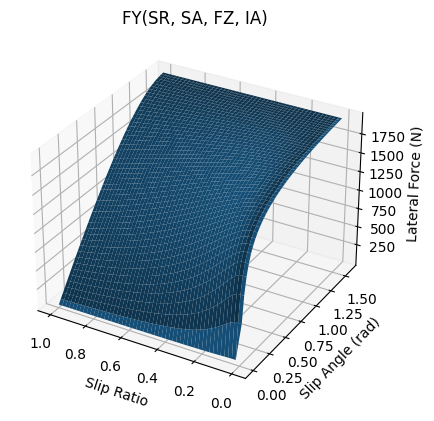

In [10]:
# Lat

fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)

ax = plt.axes(projection='3d')

fig.add_axes(ax)
ax.plot_surface(SR, SA, FY)
# ax.plot_surface(SR, SA, FY2)
# ax.plot_surface(SR, SA, FY3)

ax.set_xlabel('Slip Ratio')
ax.set_ylabel('Slip Angle (rad)')
ax.set_zlabel('Lateral Force (N)')
ax.set_title('FY(SR, SA, FZ, IA)')

ax.invert_xaxis()

C:\Users\rober\AppData\Local\Temp\ipykernel_29124\2481101389.py:9: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(SR, SA, FX)


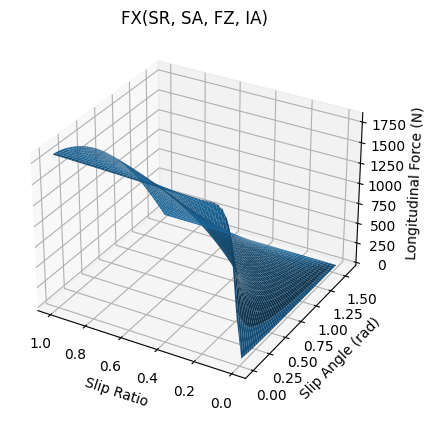

In [11]:
# Long

fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)

ax = plt.axes(projection='3d')

fig.add_axes(ax)
ax.plot_surface(SR, SA, FX)
# ax.plot_surface(SR, SA, FX2)

ax.set_xlabel('Slip Ratio')
ax.set_ylabel('Slip Angle (rad)')
ax.set_zlabel('Longitudinal Force (N)')
ax.set_title('FX(SR, SA, FZ, IA)')
ax.invert_xaxis()

In [12]:
SA = 0
SR = -0.6

forces = _get_comstock_forces(SA * np.pi / 180, SR / 100, 1200, 1.5 * np.pi / 180)

print(forces[1], forces[0])

2.0202629575974672e-60 -210.42681250921663
